In [1]:
import os
from glob import glob

import pydicom
from skimage import io

import numpy as np       # linear algebra
import pandas as pd      # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain

In [2]:
%matplotlib inline

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## **Exporatory Data Analysis**

Exploring the dataset using various EDA techniques

### **1 - Overview of the dataset**

In [3]:
# loading the dataset and viewing some samples
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(n=10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
34665,00009138_009.png,No Finding,9,9138,68,M,AP,2500,2048,0.168,0.168,NaN
31457,00008228_006.png,No Finding,6,8228,12,M,PA,2210,2753,0.143,0.143,NaN
88679,00021972_015.png,Infiltration,15,21972,49,F,AP,3056,2544,0.139,0.139,NaN
69832,00017213_002.png,No Finding,2,17213,49,F,AP,2048,2500,0.168,0.168,NaN
24580,00006463_000.png,No Finding,0,6463,53,F,PA,2048,2500,0.171,0.171,NaN
30470,00007949_002.png,Atelectasis,2,7949,38,M,AP,2500,2048,0.168,0.168,NaN
18576,00004925_010.png,No Finding,10,4925,55,M,AP,2500,2048,0.171,0.171,NaN
34138,00008942_000.png,Atelectasis|Consolidation,0,8942,51,M,AP,2500,2048,0.168,0.168,NaN
74106,00018224_008.png,Atelectasis|Consolidation|Effusion|Mass|Nodule,8,18224,59,M,AP,2500,2048,0.168,0.168,NaN
43990,00011351_025.png,Atelectasis|Infiltration,25,11351,44,M,AP,2500,2048,0.168,0.168,NaN


In [4]:
# checking the dataset shape
all_xray_df.shape

(112120, 12)

In [5]:
# an overview of the dataset properties
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [6]:
# checking for duplications
all_xray_df['Image Index'].duplicated().sum()

0

In [7]:
# dropping the "Unnamed: 11" column
# all_xray_df['Unnamed: 11'].unique()  --> [nan]

all_xray_df.drop('Unnamed: 11', axis=1, inplace=True)

In [8]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')

In [9]:
# get scans' full paths
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

In [10]:
# checking the scan and label numbers
print(f'Total scans: {len(all_image_paths)}, Total labels: {len(all_xray_df)}')

Total scans: 112120, Total labels: 112120


In [11]:
# ensuring that the labels correspond to the true images
assert set(all_xray_df['Image Index'].values) == set(all_image_paths.keys())

In [12]:
# adding data point full paths
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Atelectasis|Edema|Effusion|Hernia|Infiltration
Emphysema|Mass|Pneumothorax
Mass|Infiltration|Pneumonia
Cardiomegaly|Consolidation|Effusion|Infiltration|Nodule
Consolidation|Infiltration|Mass|Pleural_Thickening
Consolidation|Mass|Nodule
Emphysema|Infiltration|Pleural_Thickening
Atelectasis|Cardiomegaly|Pneumothorax
Fibrosis|Mass|Nodule
Infiltration|Cardiomegaly
Atelectasis|Consolidation|Emphysema|Infiltration|Pneumothorax
Effusion|Emphysema|Mass


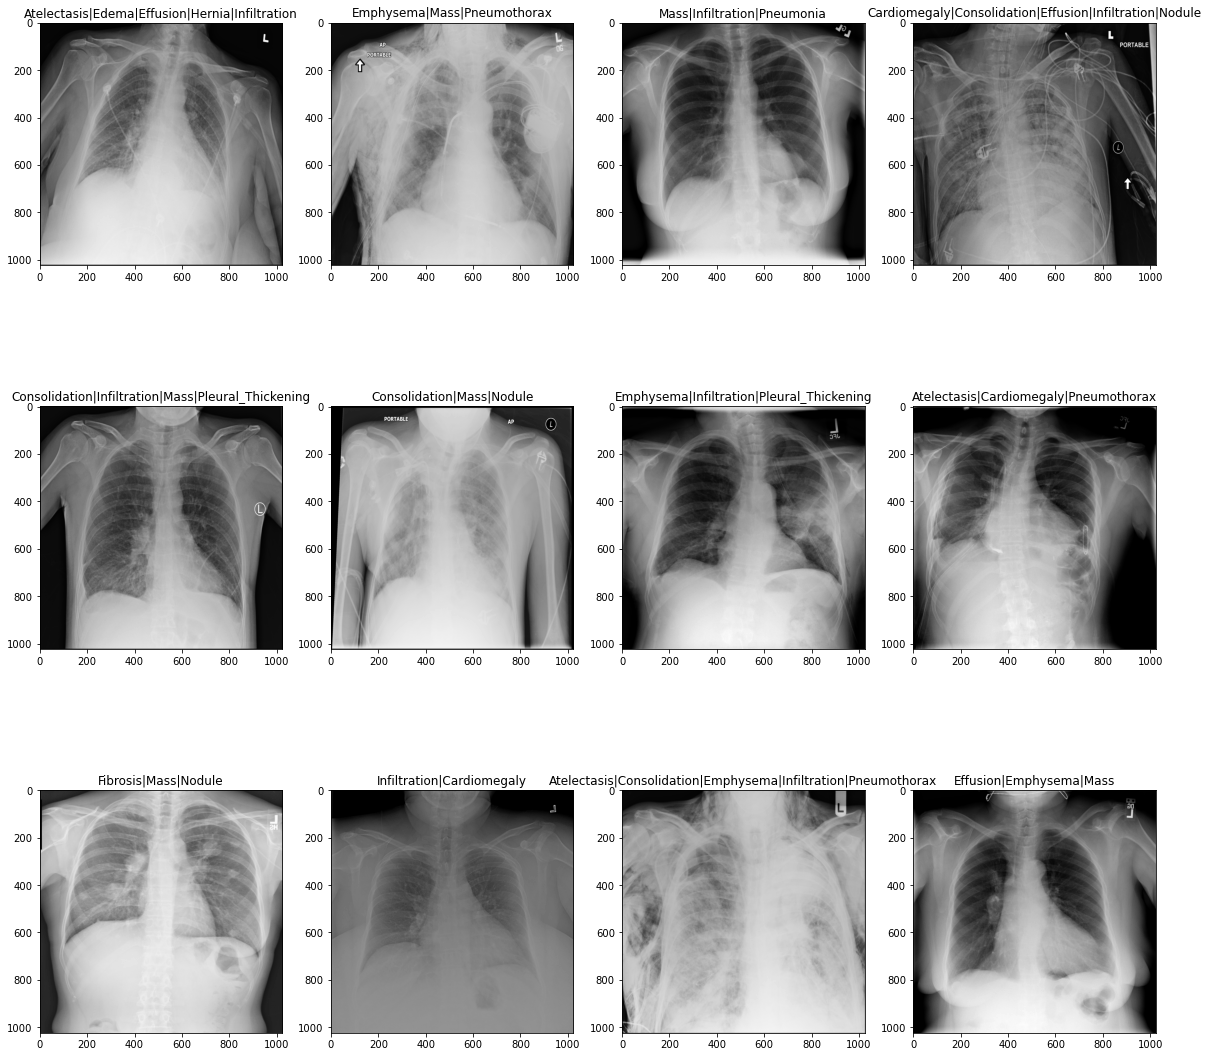

In [13]:
# visualizing some sample images
sample_df = (all_xray_df.drop_duplicates(subset='Finding Labels')
                        .sample(n=12))

fig, m_axs = plt.subplots(3, 4, figsize=(20, 20))
m_axs = m_axs.flatten()

for (label, path), ax in zip(sample_df[['Finding Labels', 'path']].values, m_axs):
    img = io.imread(path)
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    print(label)

In [14]:
# One-Hot coding for finding labels
all_labels = np.unique(list(chain.from_iterable(all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [label for label in all_labels if len(label) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].apply(lambda finding: 1 if label in finding else 0)

all_xray_df.sample(n=10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
29820,00007751_000.png,No Finding,0,7751,39,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
60724,00014996_018.png,No Finding,18,14996,50,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
43445,00011211_001.png,Infiltration,1,11211,73,M,PA,2992,2991,0.143,...,0,0,0,1,0,0,0,0,0,0
56668,00014094_001.png,No Finding,1,14094,28,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
46184,00011814_027.png,Atelectasis|Consolidation|Effusion|Pneumothorax,27,11814,70,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,1
101967,00027129_000.png,No Finding,0,27129,37,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
31057,00008068_011.png,Nodule,11,8068,41,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,1,0,0,0
50150,00012682_000.png,No Finding,0,12682,58,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
81838,00020130_008.png,No Finding,8,20130,44,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
25200,00006642_000.png,No Finding,0,6642,58,M,AP,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0


In [15]:
# creating a target column

all_xray_df['target'] = all_xray_df['Pneumonia'].apply(lambda label: 'Pneumonia' if label==1 else 'Non-Pneumonia')

all_xray_df.sample(n=10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,target
38837,00010143_000.png,Mass,0,10143,53,F,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,0,Non-Pneumonia
10458,00002706_001.png,Atelectasis|Infiltration,1,2706,49,F,PA,2048,2500,0.168,...,0,0,1,0,0,0,0,0,0,Non-Pneumonia
49510,00012573_000.png,No Finding,0,12573,17,F,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,Non-Pneumonia
31339,00008180_007.png,Atelectasis|Pneumothorax,7,8180,48,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,Non-Pneumonia
54556,00013670_063.png,Infiltration|Mass,63,13670,56,M,AP,2500,2048,0.168,...,0,0,1,1,0,0,0,0,0,Non-Pneumonia
43056,00011120_000.png,No Finding,0,11120,46,F,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,Non-Pneumonia
87919,00021755_000.png,Infiltration,0,21755,7,F,PA,2196,2152,0.139,...,0,0,1,0,0,0,0,0,0,Non-Pneumonia
100011,00026495_004.png,No Finding,4,26495,73,F,PA,2206,2991,0.143,...,0,0,0,0,1,0,0,0,0,Non-Pneumonia
102249,00027213_079.png,No Finding,79,27213,73,F,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,Non-Pneumonia
62313,00015414_015.png,Atelectasis,15,15414,40,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,Non-Pneumonia


In [16]:
# dropping Finding Labels column
all_xray_df.drop('Finding Labels', axis=1, inplace=True)

In [17]:
# info on the generated dataframe
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Follow-up #                  112120 non-null  int64  
 2   Patient ID                   112120 non-null  int64  
 3   Patient Age                  112120 non-null  int64  
 4   Patient Gender               112120 non-null  object 
 5   View Position                112120 non-null  object 
 6   OriginalImage[Width          112120 non-null  int64  
 7   Height]                      112120 non-null  int64  
 8   OriginalImagePixelSpacing[x  112120 non-null  float64
 9   y]                           112120 non-null  float64
 10  path                         112120 non-null  object 
 11  Atelectasis                  112120 non-null  int64  
 12  Cardiomegaly                 112120 non-null  int64  
 13 

In [18]:
# descriptive statistics of the dataset [only the age]
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

**Observations:**

>- the dataset contains 112,120 patients.
>- the mean age of the patients is approximately 50 years old.
>- the youngest patient is 1 year old.
>- <span style="color:#FF0000">the oldest patient is 414 years old.</span>
>- 25% of the patients are below the age of 35.
>- 50% of the patients are below the age of 49.
>- 75% of the patients are below the age of 59.

<span style="color:#0000FF">Here, the presence of a patient with an age of 414 years seems unrealistic and may indicate an issue with the dataset that requires cleaning.</span>

- **Removing patients with outlier ages**

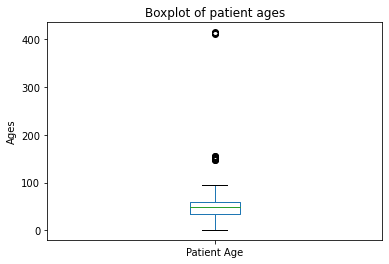

In [19]:
# boxplot to show ages interquartile range
all_xray_df['Patient Age'].plot(kind='box')
plt.title('Boxplot of patient ages')
plt.ylabel('Ages');

In [20]:
# calculating the interquartile range (IQR)
q1 = all_xray_df['Patient Age'].quantile(0.25)
q3 = all_xray_df['Patient Age'].quantile(0.75)
iqr = q3 - q1

# determining the lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# finding the outliers in the 'Patient Age' column
outliers = all_xray_df[(all_xray_df['Patient Age'] < lower_bound) | (all_xray_df['Patient Age'] > upper_bound)]

print("Outliers:")
print(outliers['Patient Age'])

Outliers:
20852     412
46965     414
48284     148
55742     148
58650     150
62929     149
74884     152
78795     151
84810     411
85404     412
86264     413
91369     412
95794     153
98495     154
101194    155
104590    155
Name: Patient Age, dtype: int64


The ages of the outliers fall within the range of [155, 412] years old.

In [21]:
# removing patients with outlier ages from the dataframe
all_xray_df = all_xray_df[(all_xray_df['Patient Age'] >= lower_bound) & (all_xray_df['Patient Age'] <= upper_bound)]

all_xray_df['Patient Age'].describe()

count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

### **2 - Patient demographic distributions**

- **Gender**

In [22]:
def plot_distribution(df,
                      feature='',
                      offset=3200,
                      xlabel = '',
                      title = ''):
    
    b_color = sns.color_palette()[0]
    value_cnts = df[feature].value_counts()
    
    plt.figure(figsize = (14,6))
    
    ax = sns.countplot(data=df, 
                 x = feature,
                 color = b_color,
                 order = value_cnts.index)
    
    for i in range(value_cnts.shape[0]):
        count = value_cnts.values[i]
        percentage = 100*count / np.sum(value_cnts)
        plt.text(i, count + offset, f'{count} ({percentage:.02f}%)', ha = 'center', va='top', fontsize=14)
    

    ax.set(xlabel=xlabel,
           ylabel='Count',
           title=title)

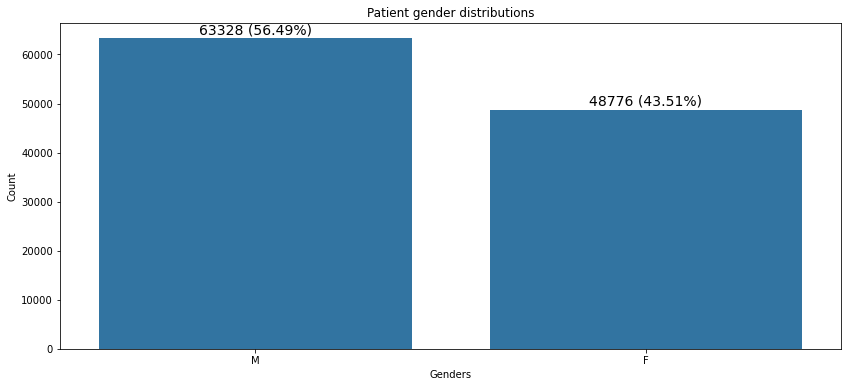

In [23]:
plot_distribution(all_xray_df, feature='Patient Gender', xlabel = 'Genders', title = 'Patient gender distributions')

56.49% of patients are women, while 43.51% are men.

- **Gender distribution for Pneumonia cases**

In [24]:
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts()

M    837
F    593
Name: Patient Gender, dtype: int64

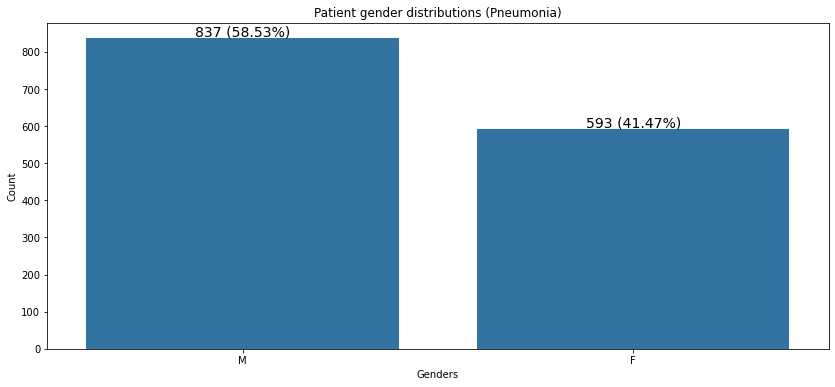

In [25]:
plot_distribution(all_xray_df[all_xray_df.Pneumonia==1], 
                  offset=35,
                  feature='Patient Gender',
                  xlabel = 'Genders', 
                  title = 'Patient gender distributions (Pneumonia)')

- There are more men with pneumonia than women with pneumonia.

- **Labels**

In [26]:
print('Find labels ({}): {}'.format(len(all_labels), all_labels))

Find labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [27]:
all_xray_df[all_labels].sum() / len(all_xray_df)*100

Atelectasis           10.310069
Cardiomegaly           2.476272
Consolidation          4.163099
Edema                  2.053450
Effusion              11.878256
Emphysema              2.244345
Fibrosis               1.503961
Hernia                 0.202491
Infiltration          17.743345
Mass                   5.155035
No Finding            53.836616
Nodule                 5.647435
Pleural_Thickening     3.018626
Pneumonia              1.275601
Pneumothorax           4.728645
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

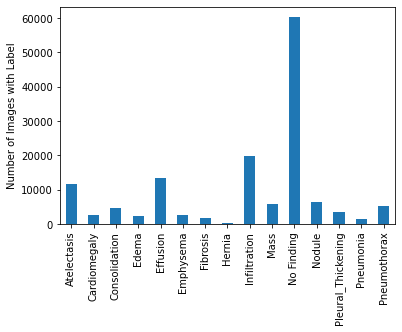

In [28]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

- 53.837% of patients are disease-free.  
- Infiltration is the most common disease and Hemia the least one.

- **Pneumonia**

In [29]:
all_xray_df['Pneumonia'].sum() / len(all_xray_df)*100

1.2756012274316706

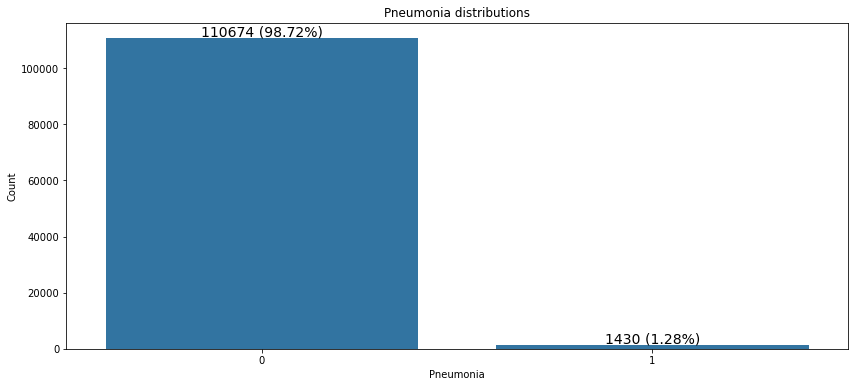

In [30]:
plot_distribution(all_xray_df, offset=4600, feature='Pneumonia', xlabel = 'Pneumonia', title = 'Pneumonia distributions')

Only 1.28% of patients show pneumonia.

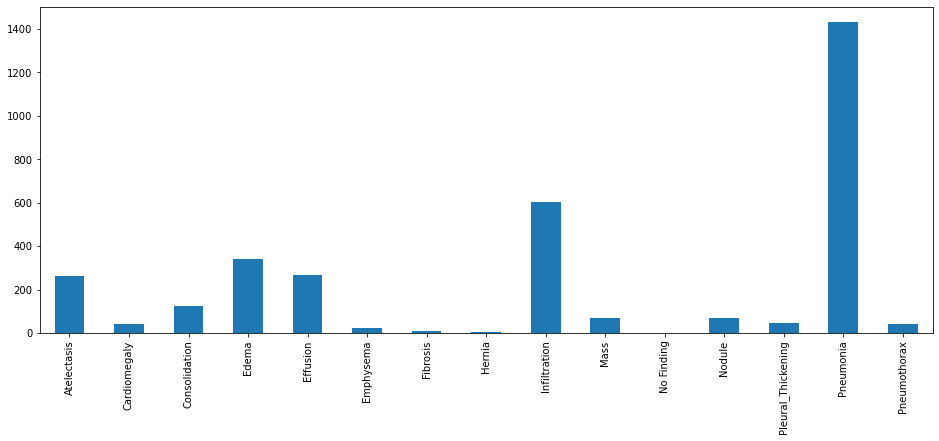

In [31]:
#The distribution of other diseases that are comorbid with pneumonia

plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1][all_labels].sum().plot(kind='bar')

- Infiltration and Edema are the most commonly co-occurring diseases with pneumonia, while Hemia and Emphysema are the least commonly co-occurring ones.

- **Age**

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

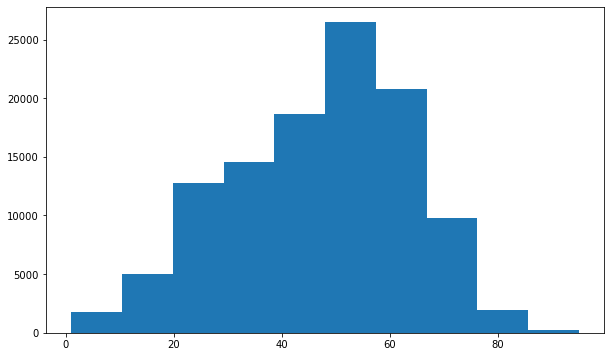

In [32]:
# age distribution in the whole dataset
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'])

In [33]:
all_xray_df['Patient Age'].value_counts().idxmax()

58

The majority of patients are around 58 years old.

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

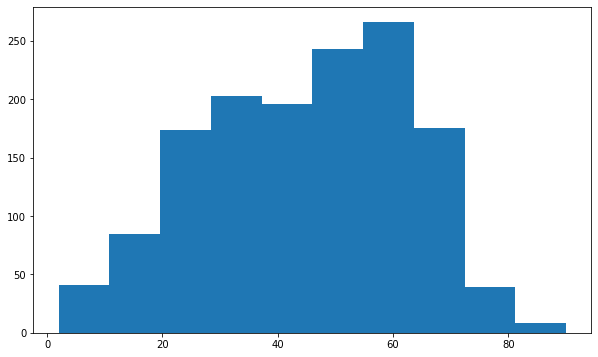

In [34]:
# age distribution for Pneumonia cases
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])

- The majority of patients with Pneumonia are around 60.

### 3 - View Position distributions

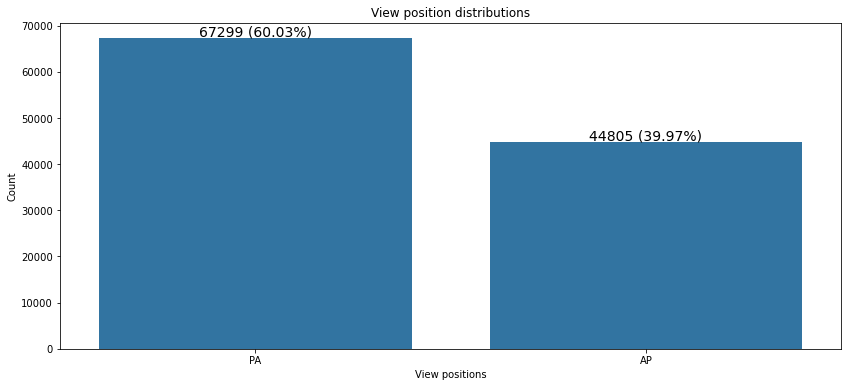

In [35]:
plot_distribution(all_xray_df, offset=2800, 
                  feature='View Position',
                  xlabel = 'View positions', 
                  title = 'View position distributions')

- 60.03% of the images in the dataset are taken from the PA (Posterior-Anterior) view position, while 39.97% are taken from the AP (Anterior-Posterior) view position.

### 4 - Number of disease per patient (Descriptive statistics)

In [36]:
temp_df = all_xray_df[all_xray_df['No Finding']==0][all_labels].copy() # No Finding is not a disease
temp_df['Total'] = temp_df.sum(axis=1)

print('The ill patients have a minimum of ({}) diseases.'.format(temp_df['Total'].min()))
print('The ill patients have an average of ({}) diseases.'.format(int(round(temp_df['Total'].mean()))))
print('The ill patients have a maximum of ({}) diseases.'.format(temp_df['Total'].max()))

The ill patients have a minimum of (1) diseases.
The ill patients have an average of (2) diseases.
The ill patients have a maximum of (9) diseases.


In [39]:
all_xray_df.shape

(112104, 27)

In [41]:
# save the cleaned data
all_xray_df.to_csv('cleaned_data.csv', index=False)